In [111]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [60]:
# Import logins.json file which contains (simulated) timestamps of user logins in a particular geographic location
data = pd.read_json('logins.json')
data.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Aggregate login counts based on 15 minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand

In [61]:
data.dtypes

login_time    datetime64[ns]
dtype: object

In [62]:
data['count']=1
data.head()

,login_time,count
0,1970-01-01 20:13:18,1
1,1970-01-01 20:16:10,1
2,1970-01-01 20:16:37,1
3,1970-01-01 20:16:36,1
4,1970-01-01 20:26:21,1


In [72]:
#converted = data.asfreq('15Min', method='pad')
data_15Min = data.set_index('login_time').resample('15Min').sum()

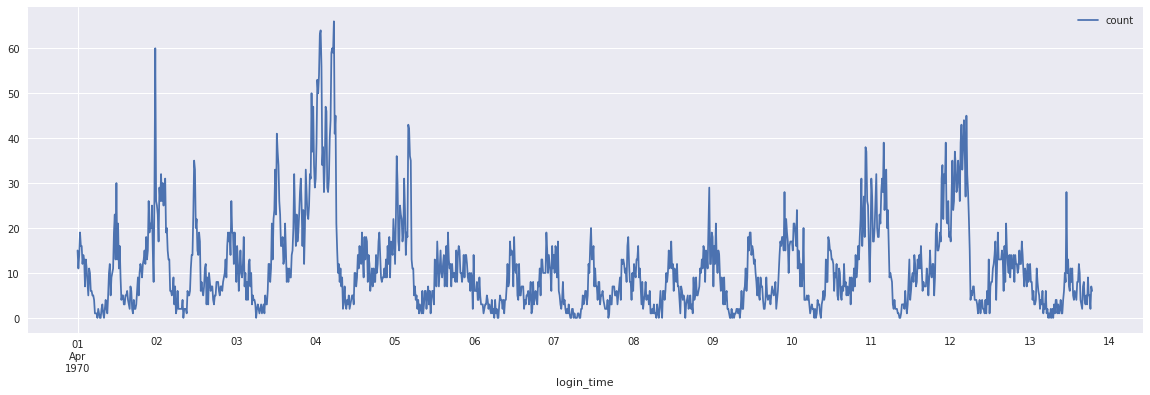

In [105]:
data_15Min['1970-Apr'].plot(figsize=(20,6))
plt.show()

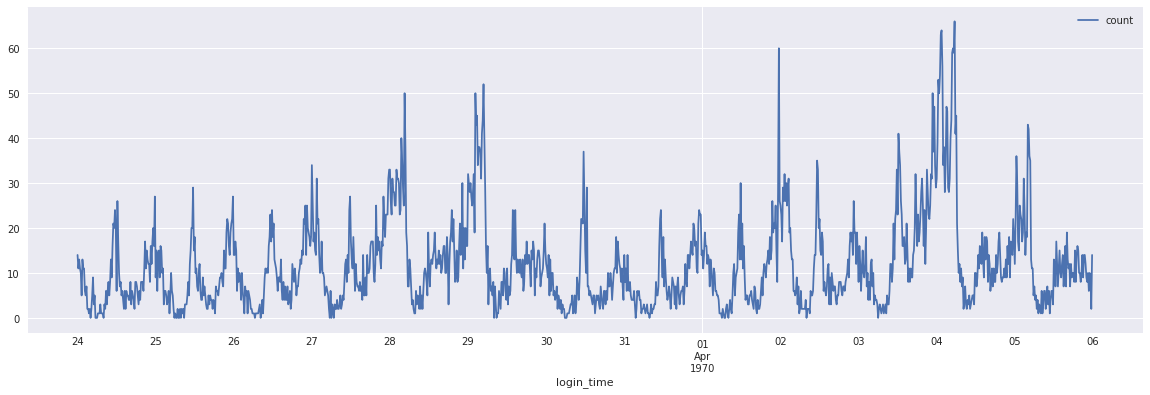

In [102]:
data_15Min['1970-Mar-24':'1970-Apr-05'].plot(figsize=(20,6))
plt.show()

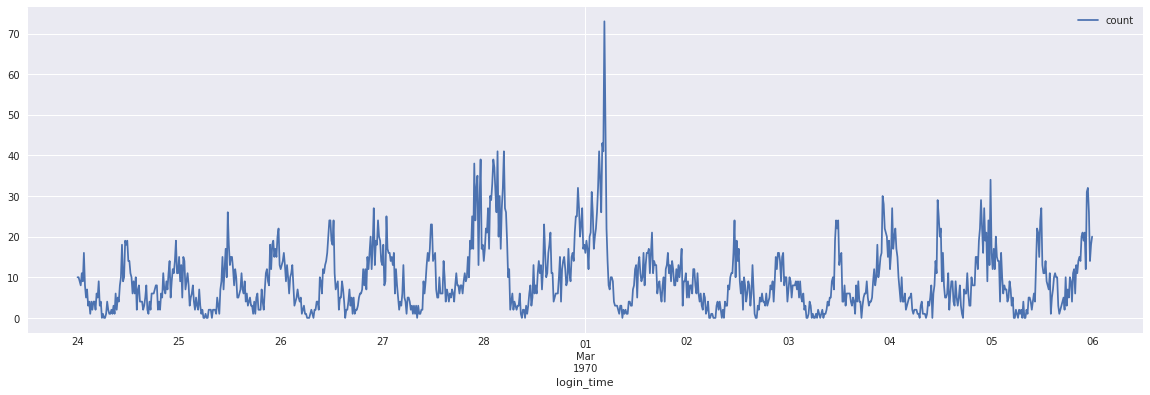

In [106]:
data_15Min['1970-Feb-24':'1970-Mar-05'].plot(figsize=(20,6))
plt.show()

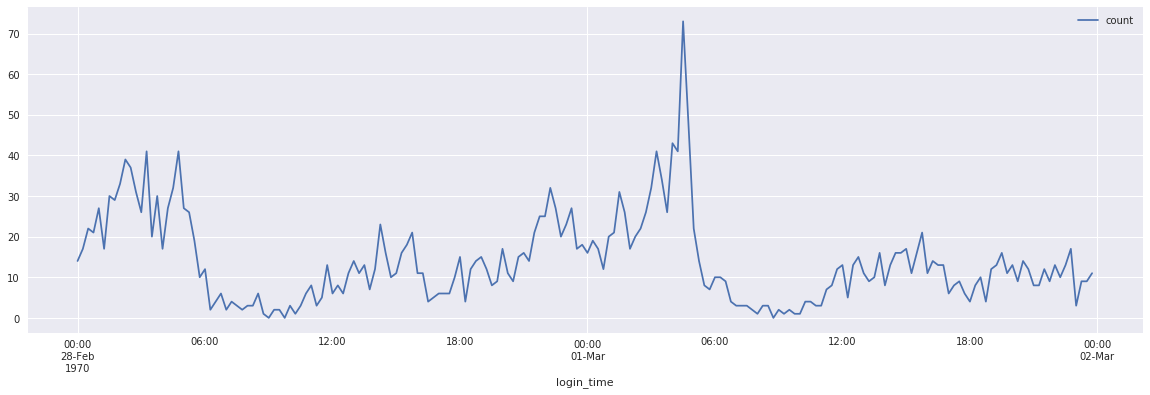

In [107]:
data_15Min['1970/Feb/28':'1970-Mar-01'].plot(figsize=(20,6))
plt.show()

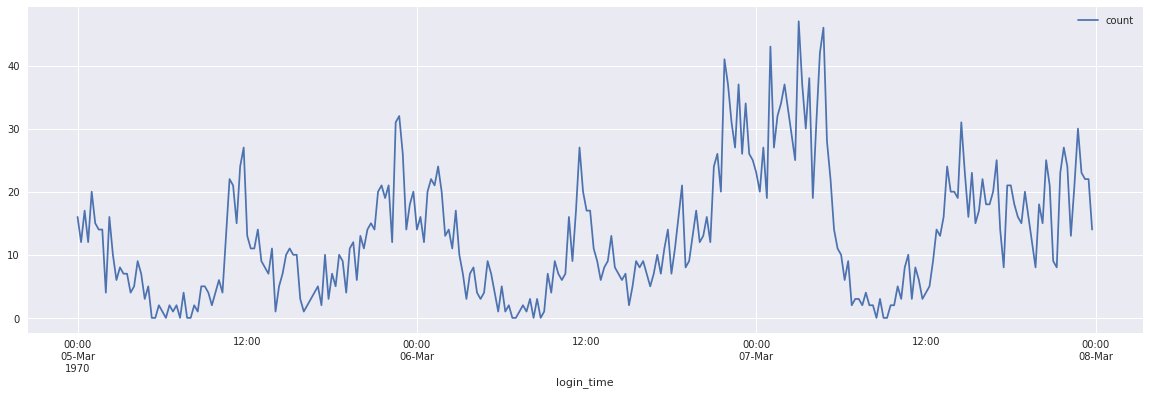

In [108]:
data_15Min['1970/03/05':'1970-03-07'].plot(figsize=(20,6))
plt.show()

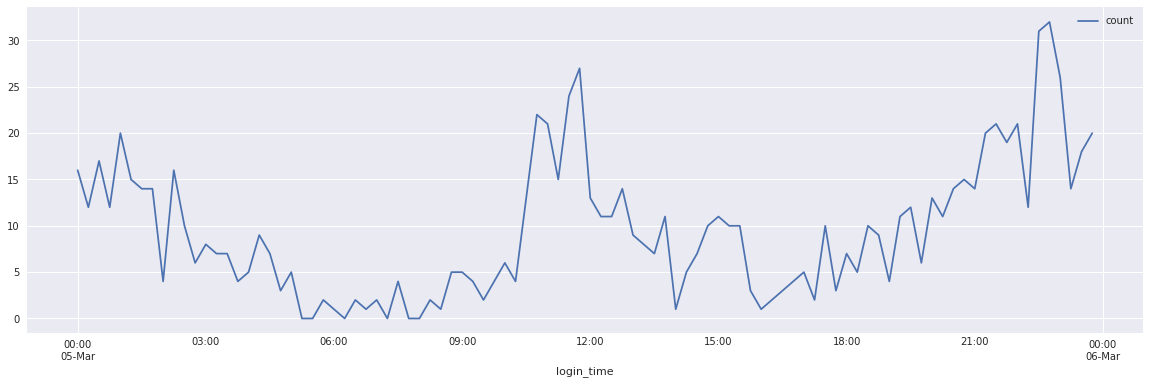

In [109]:
data_15Min['1970/03/05':'1970/03/05'].plot(figsize=(20,6))
plt.show()

It looks like there is trend of logins around 12:00PM, then downfall and increase towards 12:00AM. The peak comes aroung 12:00AM.

## Experiment and Metrics Design

**Success Metrics**


Assumption : Demand is equal for both cities. It means that demand at night in Gotham is the same as that at night in Metropolis.

Since there is reasonable activity on the weekends, I will focus on weekdays.

The success metric I propose would be the ratio of passengers picked up from Gotham and Metropolis in the weekdays. After the introduction of this experiment, if the ratio has remained 1:1, this would mean that the experiment was successful.

**Experiment**

These are the steps I would implement:

  - Keep track of the activity of the drivers in each city. If we come across an increase of tendency towards a driver in Gotham City, label him/her as a Gotham Driver. Else label him/her as Metropolis Driver.
  - Then we are supposed to provide the proportion of passengers from two cities and seperate them into two sample groups: prior to the experiment and after the experiment.
  - Perform hypothesis testing using the Difference of Proportions test on the two samples. Calculate the Z-Statisitc and the p-value and compare it with an arbritrary significance level, $\alpha$.
  - If the Null Hypothesis holds, it implies that the experiment has been a failure. If the Alternate hypothesis holds, it implies that it has been a success.

## Predictive Modeling¶


In [112]:
with open('ultimate_data_challenge.json') as f:
   data = json.load(f)

df = pd.DataFrame(data)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [114]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)

In [115]:
df['retention'] = df.last_trip_date.apply(lambda x: 1 if (x >= pd.Timestamp('2014-6-1')) & 
                                                    (x <= pd.Timestamp('2014-7-1')) else 0)
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retention
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [116]:
df.retention.value_counts()

0    31196
1    18804
Name: retention, dtype: int64

In [117]:
df_dropped = df.dropna()


In [118]:
print(df_dropped.shape[0]/df.shape[0])


0.8289


In [119]:
round(df_dropped.retention.sum() /  len(df_dropped) * 100,4)


41.1027

In [121]:
print('Active Users by City')
print(df_dropped.groupby('city').retention.sum() / df_dropped.groupby('city').retention.count())

Active Users by City
city
Astapor           0.283441
King's Landing    0.653675
Winterfell        0.389854
Name: retention, dtype: float64


In [122]:
print('Active Users by Phone:')
print(df_dropped.groupby('phone').retention.sum() / df_dropped.groupby('phone').retention.count())

Active Users by Phone:
phone
Android    0.231870
iPhone     0.484839
Name: retention, dtype: float64


In [123]:
grouped = df_dropped.groupby(['city', 'phone'])

for x in grouped.groups.keys():
    group = grouped.get_group(x)
    pct = 100 * (group.retention.sum() / len(group))
    print('{:.2f}% of the {} {} users in {} were active'.format(pct, len(group), x[1], x[0]))


13.22% of the 4190 Android users in Astapor were active
35.14% of the 9319 iPhone users in Astapor were active
46.58% of the 2104 Android users in King's Landing were active
71.29% of the 6671 iPhone users in King's Landing were active
21.90% of the 5799 Android users in Winterfell were active
46.40% of the 13362 iPhone users in Winterfell were active


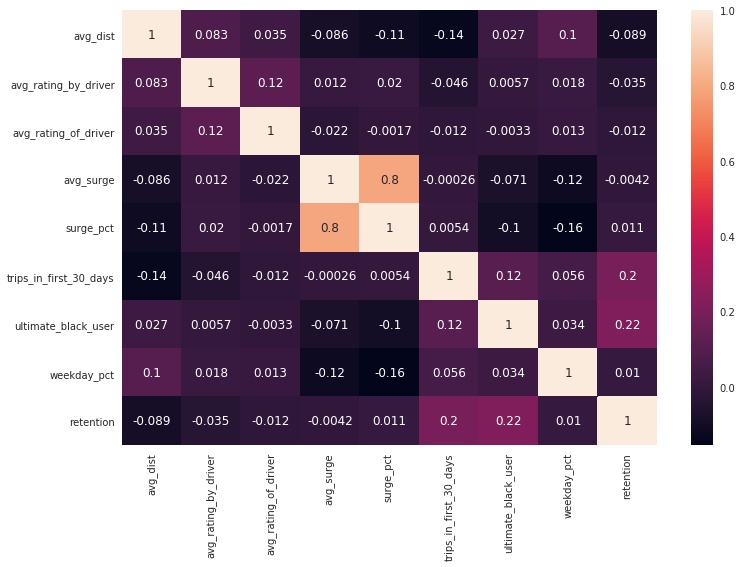

In [125]:
import seaborn as sns
plt.subplots(figsize=(12,8))
sns.heatmap(df_dropped.corr(), annot=True)
plt.show()

In [126]:
df_dropped.head()


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retention
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0


In [129]:
import sys
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for column_name in df_dropped.columns:
    if df_dropped[column_name].dtype == object:
        df_dropped[column_name] = le.fit_transform(df_dropped[column_name])
    else:
        pass

In [131]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score


random_state = 8
model = RandomForestClassifier(n_estimators=25, random_state=random_state)

kfold = StratifiedKFold(n_splits=10, random_state=random_state)
print('Accuracy: {:.4f}'.format(cross_val_score(model, 
                                                df_dropped.drop(['last_trip_date', 'signup_date', 
                                                                     'retention'],axis=1), df_dropped.retention, 
                                                cv=kfold, scoring='accuracy').mean()))
print('Precision: {:.4f}'.format(cross_val_score(model, df_dropped.drop
                                                 (['last_trip_date', 'signup_date', 'retention'],axis=1), 
                                                 df_dropped.retention, cv=kfold, scoring='precision').mean()))
print('Recall: {:.4f}'.format(cross_val_score(model, 
                                              df_dropped.drop(['last_trip_date', 'signup_date','retention'],axis=1)
                                              , df_dropped.retention, cv=kfold, scoring='recall').mean()))

Accuracy: 0.7449
Precision: 0.6922
Recall: 0.6834


In [132]:
model.fit(df_dropped.drop(['last_trip_date', 'signup_date', 'retention'],axis=1), df_dropped.retention)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=1,
            oob_score=False, random_state=8, verbose=0, warm_start=False)

Feature ranking:
1. feature 0 (0.282738)
2. feature 9 (0.138888)
3. feature 1 (0.105797)
4. feature 6 (0.093736)
5. feature 7 (0.081084)
6. feature 2 (0.078481)
7. feature 3 (0.077939)
8. feature 4 (0.068245)
9. feature 5 (0.039291)
10. feature 8 (0.033800)


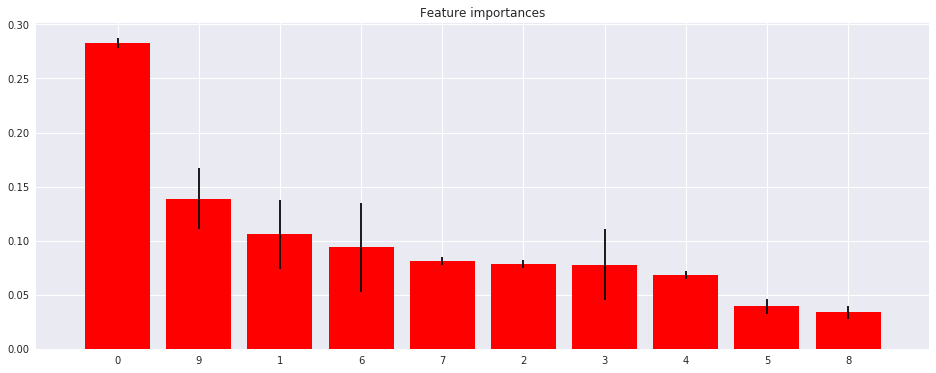

In [134]:
import numpy as np

importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(df_dropped.drop(['last_trip_date', 'signup_date', 'retention'],axis=1).shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(df_dropped.drop(['last_trip_date', 'signup_date', 'retention'],axis=1).shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(df_dropped.drop(['last_trip_date', 'signup_date', 'retention'],axis=1).shape[1]), indices)
plt.xlim([-1, df_dropped.drop(['last_trip_date', 'signup_date', 'retention'],axis=1).shape[1]])
plt.show()